In [27]:
%pylab
from PyMouSh import MoulinShape, TimeStamps, Qin_sinusoidal, Qin_real
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import os

secinday = 24*3600
ZERO_KELVIN = 273.15
timestep = 300
supraglacial_baseflow = 0.1

def find_nearest_idx(array, value):
    """Finds the nearest value in an array and outputs a index.
    This function was found in 
    https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array

    Parameters:
    -----------
    array: array to be looked into
    value: single value to look for into the array

    Output:
    -------
    index of the closest value in the array
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def Fill_dict(Q_csv_name,head_csv_name,timestep):
    dictionnary = defaultdict(list)
    
    tmp1 = pd.read_csv(Q_csv_name)
    tmp1 = tmp1.dropna()
    Qin = tmp1.Qm3s.to_numpy() + supraglacial_baseflow
    Qtime = tmp1.SOY.to_numpy()
        
    #time array in seconds
    dictionnary['meltwater_time'] = TimeStamps(Qtime[0],Qtime[-1],timestep)
    dictionnary['meltwater_data'] = Qin_real(dictionnary['meltwater_time'], Qin, Qtime)
    
    tmp2 = pd.read_csv(head_csv_name)
    tmp2 = tmp2.dropna()
    dictionnary['h_real'] = tmp2.head_bed.to_numpy()
    dictionnary['t_real'] = tmp2.soy.to_numpy()
    return dictionnary

def Fill_dict_real(head_csv_name):
    dictionnary = defaultdict(list)
    tmp2 = pd.read_csv(head_csv_name)
    tmp2 = tmp2.dropna()
    dictionnary['h_real'] = tmp2.head_bed.to_numpy()
    dictionnary['t_real'] = tmp2.soy.to_numpy()
    return dictionnary


#temperature profile -- same for all
tmp = pd.read_csv('Field_Data/temperature_foxx1.csv')
temperature_profile = tmp.temperature.to_numpy() #np.array([ZERO_KELVIN, ZERO_KELVIN])#

#field data dictionnaries
tmp = pd.read_csv('Field_Data/surface_discharge_andrews2014_1h_smooth.csv')
tmp = tmp.dropna()

m3 = Fill_dict_real('Field_Data/head_m3.csv')
Qin = tmp.m3_m3s_1h_24hS.to_numpy() + supraglacial_baseflow
Qin[Qin<0]=0
Qtime = tmp.UTC_SOY_1h.to_numpy()
m3['meltwater_time'] = TimeStamps(Qtime[0],Qtime[-1],300)
m3['meltwater_data'] = Qin_real(m3['meltwater_time'], Qin, Qtime)

m4 = Fill_dict_real('Field_Data/head_m4.csv')
Qin = tmp.m4_m3s_1h_24hS.to_numpy() + supraglacial_baseflow
Qin[Qin<0]=0
Qtime = tmp.UTC_SOY_1h.to_numpy()
m4['meltwater_time'] = TimeStamps(Qtime[0],Qtime[-1],300)
m4['meltwater_data'] = Qin_real(m3['meltwater_time'], Qin, Qtime)

foxx = Fill_dict_real('Field_Data/head_mf.csv')
Qin = tmp.mF_m3s_1h_24hS.to_numpy() + supraglacial_baseflow
Qin[Qin<0]=0
Qtime = tmp.UTC_SOY_1h.to_numpy()
foxx['meltwater_time'] = TimeStamps(Qtime[0],Qtime[-1],300)
foxx['meltwater_data'] = Qin_real(m3['meltwater_time'], Qin, Qtime)

jeme = Fill_dict('Field_Data/surface_melt_jeme.csv','Field_Data/head_jeme.csv',timestep)
pira = Fill_dict('Field_Data/surface_melt_pira.csv','Field_Data/head_pira.csv',timestep)
radi = Fill_dict('Field_Data/surface_melt_radi.csv','Field_Data/head_radi.csv',timestep)

#glacier properties (from readme)
m3['ice_thickness'] = 560
m4['ice_thickness'] = 540
foxx['ice_thickness'] = 620
jeme['ice_thickness'] = 500
pira['ice_thickness'] = 500
radi['ice_thickness'] = 700

jeme['baseflow_one'] = np.ones(len(jeme['meltwater_time']))
pira['baseflow_one'] = np.ones(len(pira['meltwater_time']))
radi['baseflow_one'] = np.ones(len(radi['meltwater_time']))
m3['baseflow_one'] = np.ones(len(m3['meltwater_time']))
m4['baseflow_one'] = np.ones(len(m4['meltwater_time']))
foxx['baseflow_one'] = np.ones(len(foxx['meltwater_time']))

m3['name'] = 'M3'
m4['name'] = 'M4'
foxx['name'] = 'FOXX'
jeme['name'] = 'JEME'
pira['name'] = 'PIRA'
radi['name'] = 'RADI'

m3['time_lim'] = [150,250]
m4['time_lim'] = [150,250]
foxx['time_lim'] = [150,250]
jeme['time_lim'] = [182,250]
pira['time_lim'] = [200,250]
radi['time_lim'] = [208,250]

#surface slope from hoffman 2016 supplemental

def calc_and_make1plot( dataset,
                        initial_subglacial_area = (np.pi*0.75**2)/2,
                        fluidity_coefficient_SUB = 6e-24,
                        channel_length = 25000,
                        creep_factor = 3, 
                        baseflow = 0, 
                        friction = 0.1,
                        regional_surface_slope = 0.01,
                        path = 'figure_movie_AGU/',
                        make_directory = False,
                        min_radius = 0.1,
                        make_all_plots = False): 
    
    params =  dataset['name']+'_baseflow%d'%baseflow + '_channel%d'%channel_length + '_creep%d'%creep_factor + '_friction%e.1'%friction + 'fluidity_coefficient_SUB%e.1'%fluidity_coefficient_SUB 
    if make_directory == True:
        directory = dataset['name'] + params + '/'
        os.mkdir(path + directory)
    moulin_sim = MoulinShape(channel_length = channel_length,
                            temperature_profile = temperature_profile,                   
                            ice_thickness = dataset['ice_thickness'],
                            regional_surface_slope = regional_surface_slope,
                            initial_subglacial_area = initial_subglacial_area, 
                            friction_factor_SUB = friction,
                            creep_enhancement_factor = creep_factor,
                            fluidity_coefficient_SUB = fluidity_coefficient_SUB,                              
                            )

    portion = (dataset['meltwater_time'] > dataset['time_lim'][0]*secinday) & (dataset['meltwater_time'] < dataset['time_lim'][1]*secinday)
    time = dataset['meltwater_time'][portion]
    #create directory to save figures



    #calculate simulation
    for idx,t in enumerate(time):
        meltwater = dataset['meltwater_data'][dataset['meltwater_time']==t]
        moulin_sim.run1step(t,timestep,meltwater,
                            subglacial_baseflow = baseflow,
                            potential_drop=False,
                            open_channel_melt=True,
                            min_radius = min_radius 
                            )

    #plot simulation
    if make_all_plots == True:
        for idx,t_end in enumerate(time):              
            t_start = t_end-time[-1]+time[0]
            fig = plt.figure(figsize=(13,5),dpi=150)
            fig.suptitle(dataset['name'], fontsize=16)
            moulin_sim.plot_AGU_4(fig,t_start, t_end,
                                 dataset['t_real']-5*3600,dataset['h_real'],
                                 spine_head_min=200,
                                 ground_depth=-60,
                                 Q_lim = [min(dataset['meltwater_data']),max(dataset['meltwater_data'])],
                                 SC_lim = [min(moulin_sim.dict['subglacial_radius']),max(moulin_sim.dict['subglacial_radius'])],
                                 display_baseflow = False)

            plt.savefig(path + directory + '_no%d.png'%idx)
            # plt.clf()
            # plt.close(fig)
            # del fig
    else:
        t_end = time[-1]
        t_start = t_end-time[-1]+time[0]
        fig = plt.figure(figsize=(13,5),dpi=150)
        fig.suptitle(dataset['name'], fontsize=16)
        moulin_sim.plot_AGU_4(fig,t_start, t_end,
                             dataset['t_real']-5*3600,dataset['h_real'],
                             spine_head_min=200,
                             ground_depth=-60,
                             Q_lim = [min(dataset['meltwater_data']),max(dataset['meltwater_data'])],
                             SC_lim = [min(moulin_sim.dict['subglacial_radius']),max(moulin_sim.dict['subglacial_radius'])],
                             display_baseflow = False)
        plt.savefig(path + params + '_no%d.png'%idx)
        
        return moulin_sim, params,time
    
    




Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


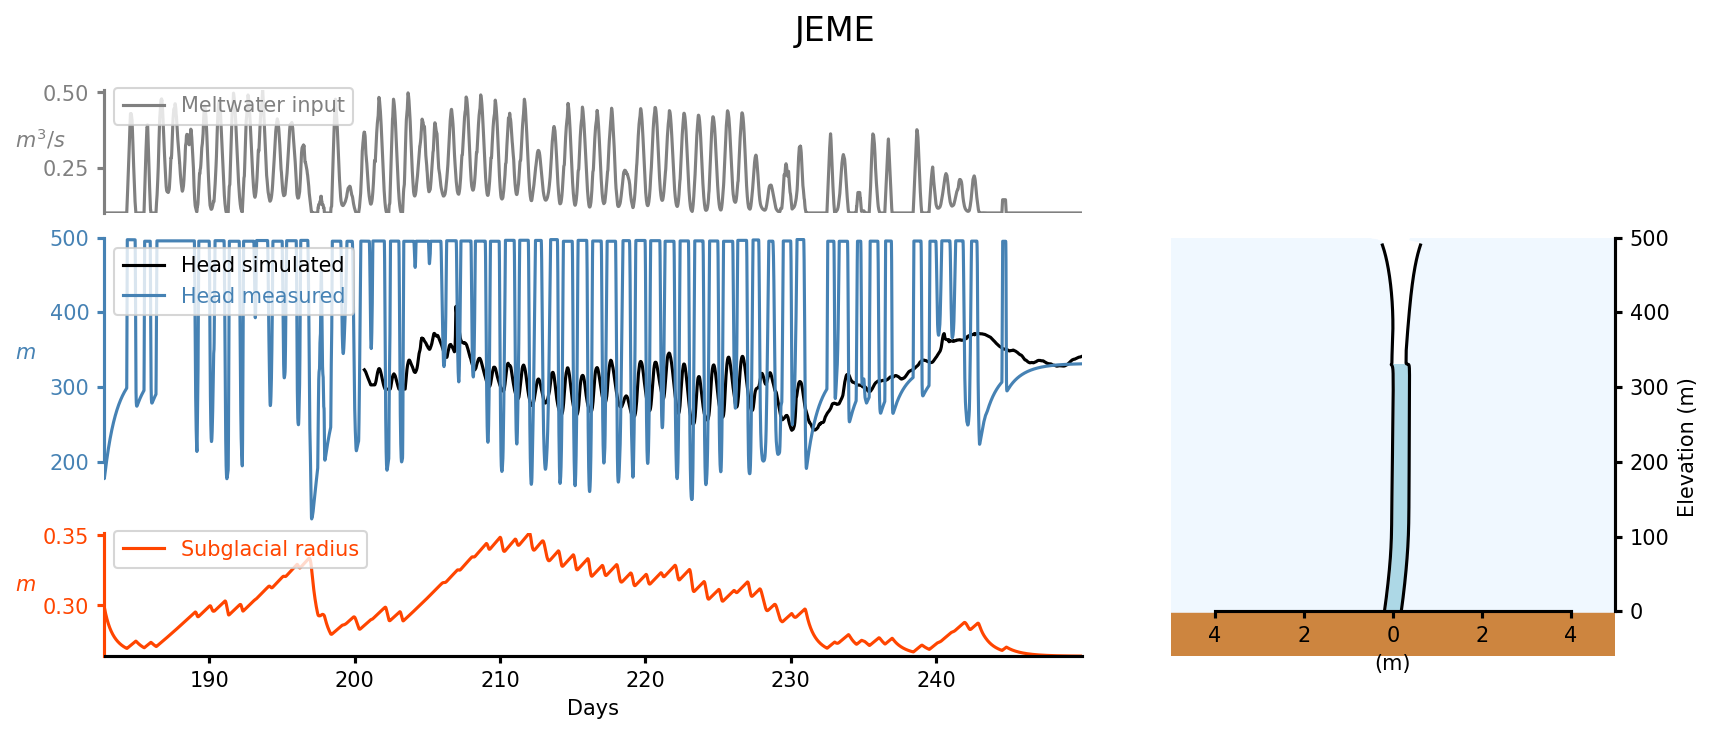

In [2]:
make_all_plots = False
make_directory = False
jeme_brut, params_jeme_brut, time_brut= calc_and_make1plot(jeme,
                                                       initial_subglacial_area = (np.pi*0.3**2)/2,
                                                       make_all_plots = make_all_plots, 
                                                       make_directory = make_directory)


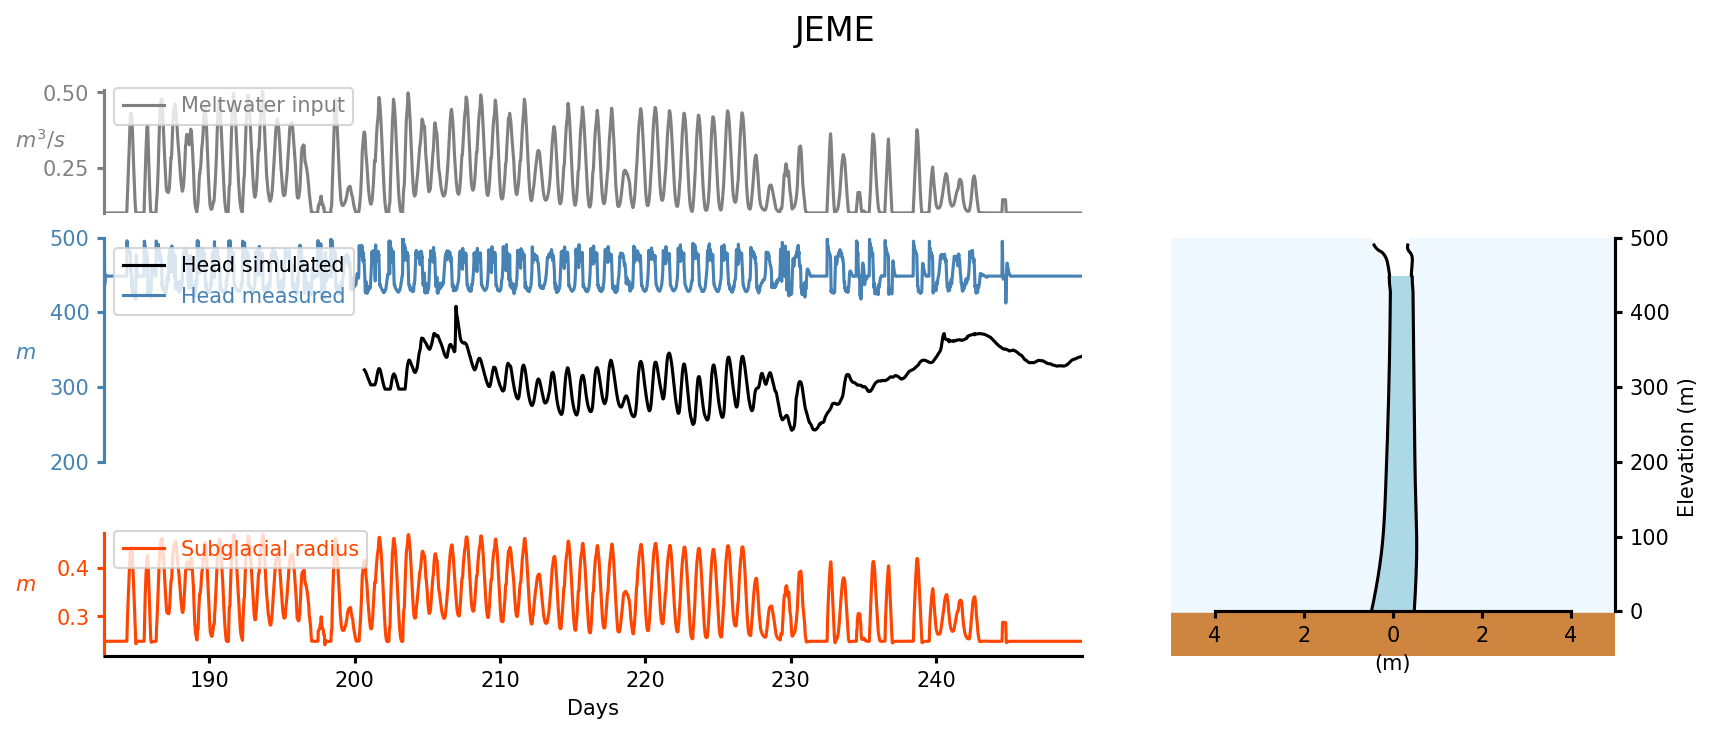

In [3]:
jeme_largeA,params_jeme_largeA, time_jeme_largeA = calc_and_make1plot(jeme, 
                                                    initial_subglacial_area = (np.pi*0.3**2)/2,
                                                    make_all_plots = make_all_plots,
                                                    make_directory = make_directory, 
                                                    fluidity_coefficient_SUB = 6e-20)


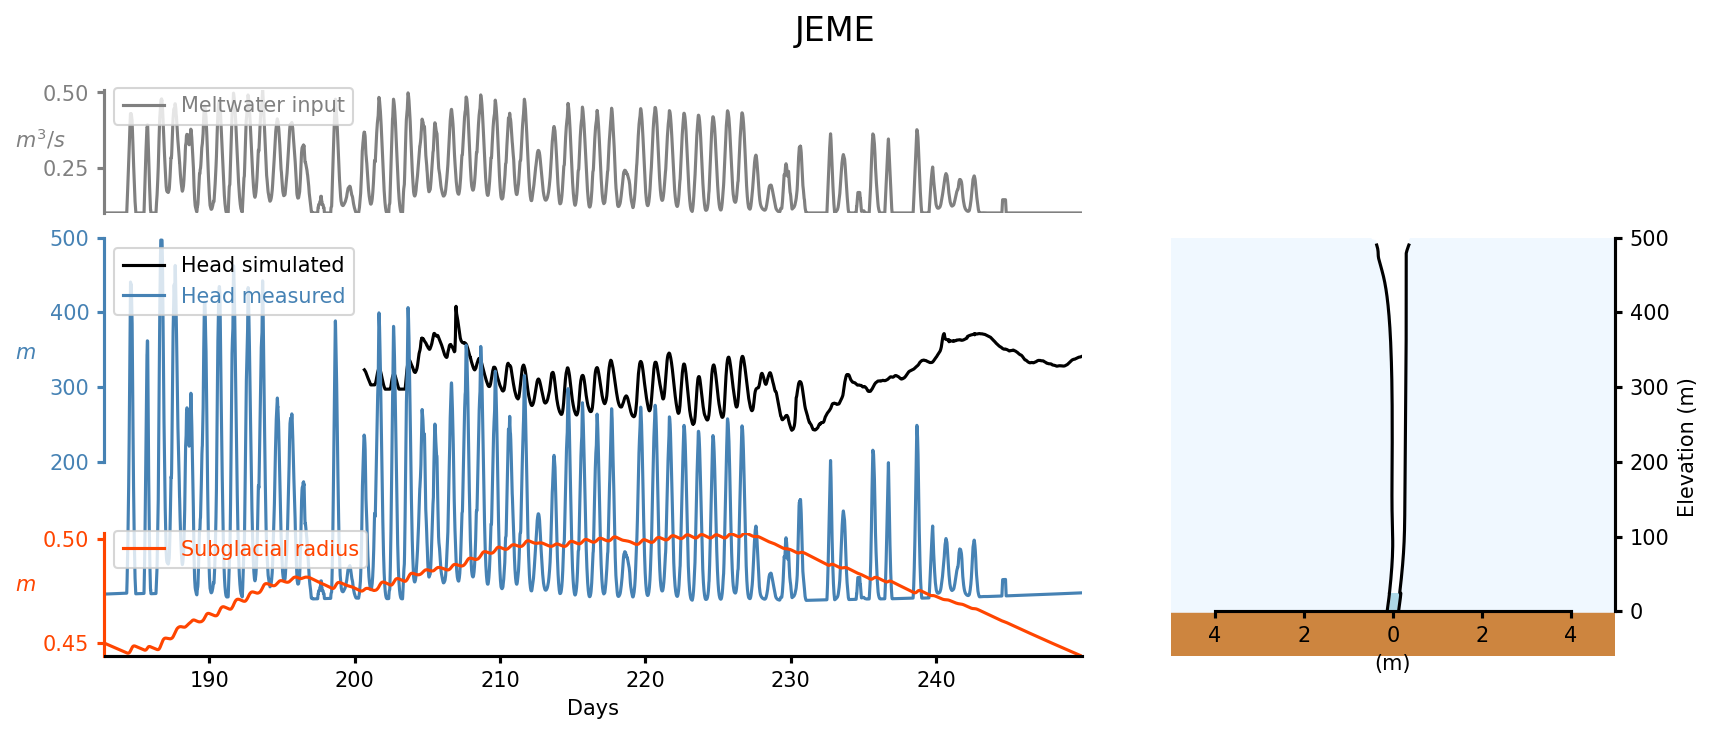

In [14]:
jeme_smallA,params_jeme_smallA, time_jeme_smallA = calc_and_make1plot(jeme, 
                                                    initial_subglacial_area = (np.pi*0.45**2)/2,
                                                    make_all_plots = make_all_plots, 
                                                    make_directory = make_directory,  
                                                    fluidity_coefficient_SUB = 6e-26)


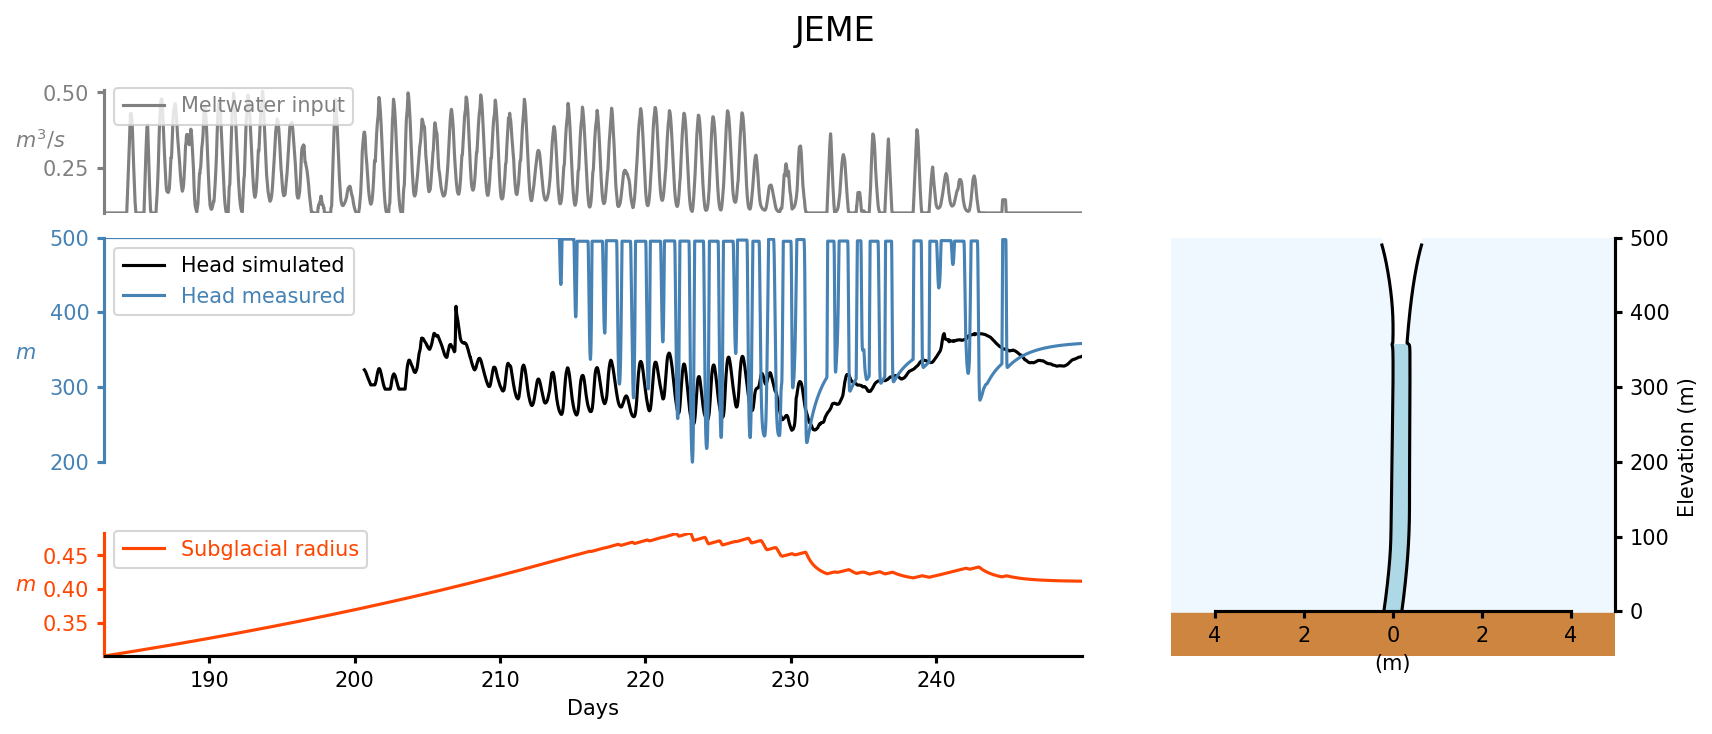

In [5]:
jeme_largef,params_jeme_largef, time_jeme_largef = calc_and_make1plot(jeme, 
                                                    initial_subglacial_area = (np.pi*0.3**2)/2,
                                                    make_all_plots = make_all_plots, 
                                                    make_directory = make_directory,  
                                                    friction = 1)


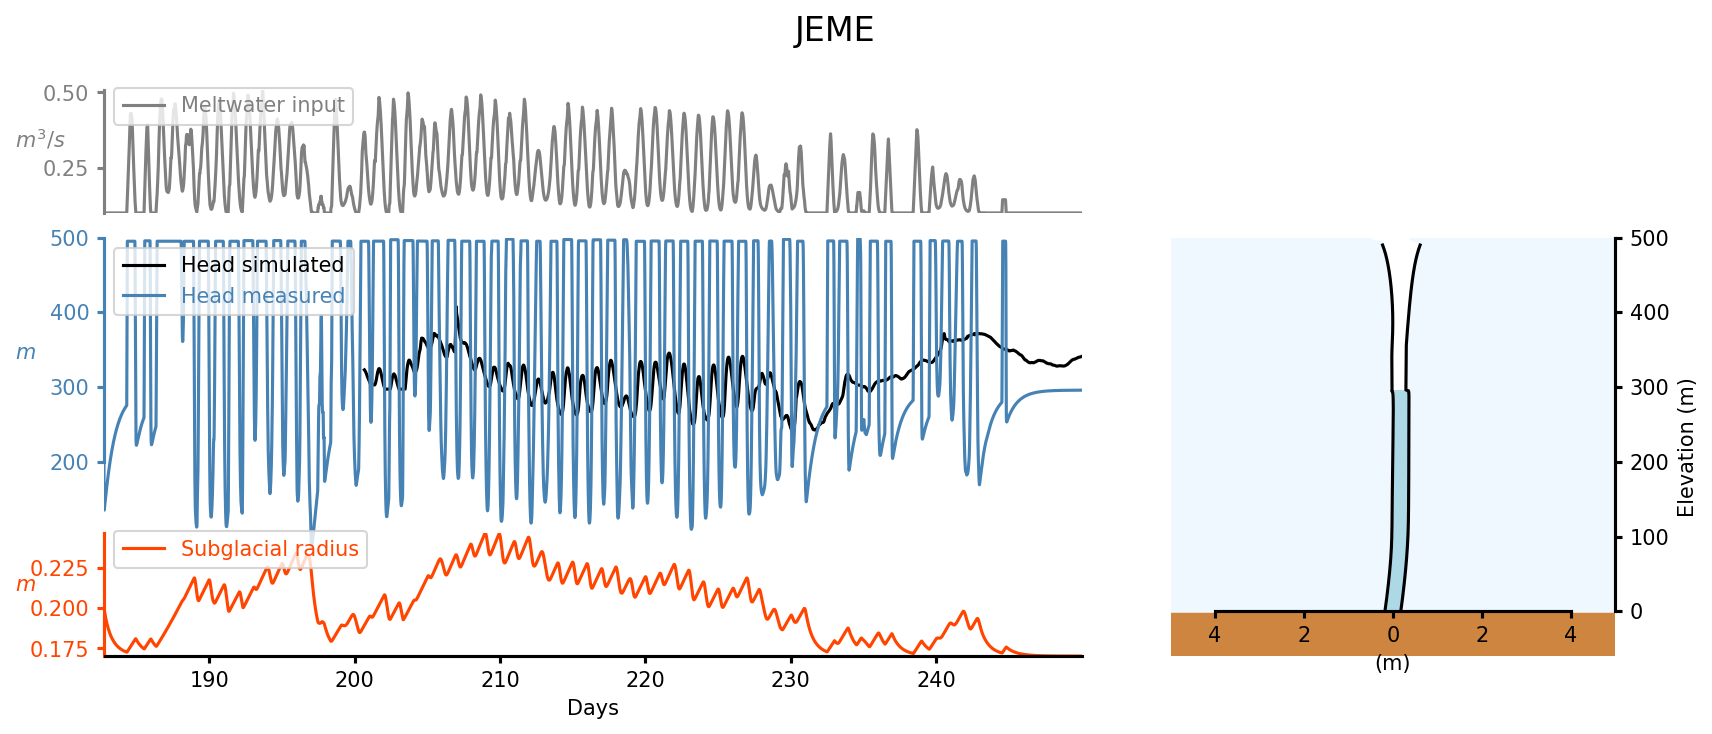

In [6]:
jeme_smallf,params_jeme_smallf, time_jeme_smallf = calc_and_make1plot(jeme, 
                                                    initial_subglacial_area = (np.pi*0.2**2)/2,
                                                    make_all_plots = make_all_plots, 
                                                    make_directory = make_directory, 
                                                    friction = 0.01)


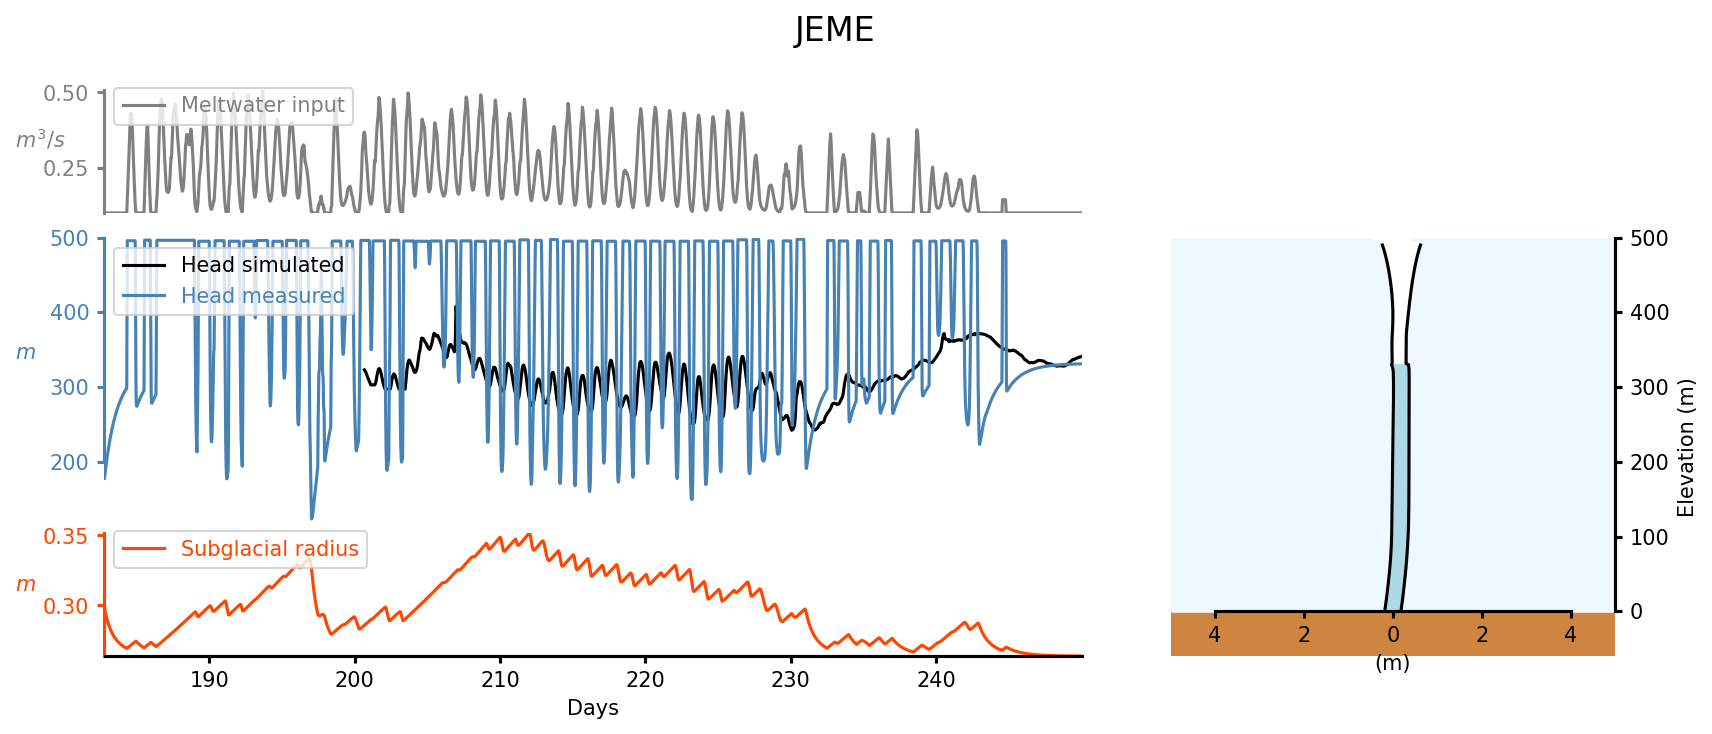

In [7]:
jeme_largeE,params_jeme_largeE, time_jeme_largeE = calc_and_make1plot(jeme, 
                                                    initial_subglacial_area = (np.pi*0.3**2)/2,
                                                    make_all_plots = make_all_plots, 
                                                    make_directory = make_directory,  
                                                    creep_factor = 6)


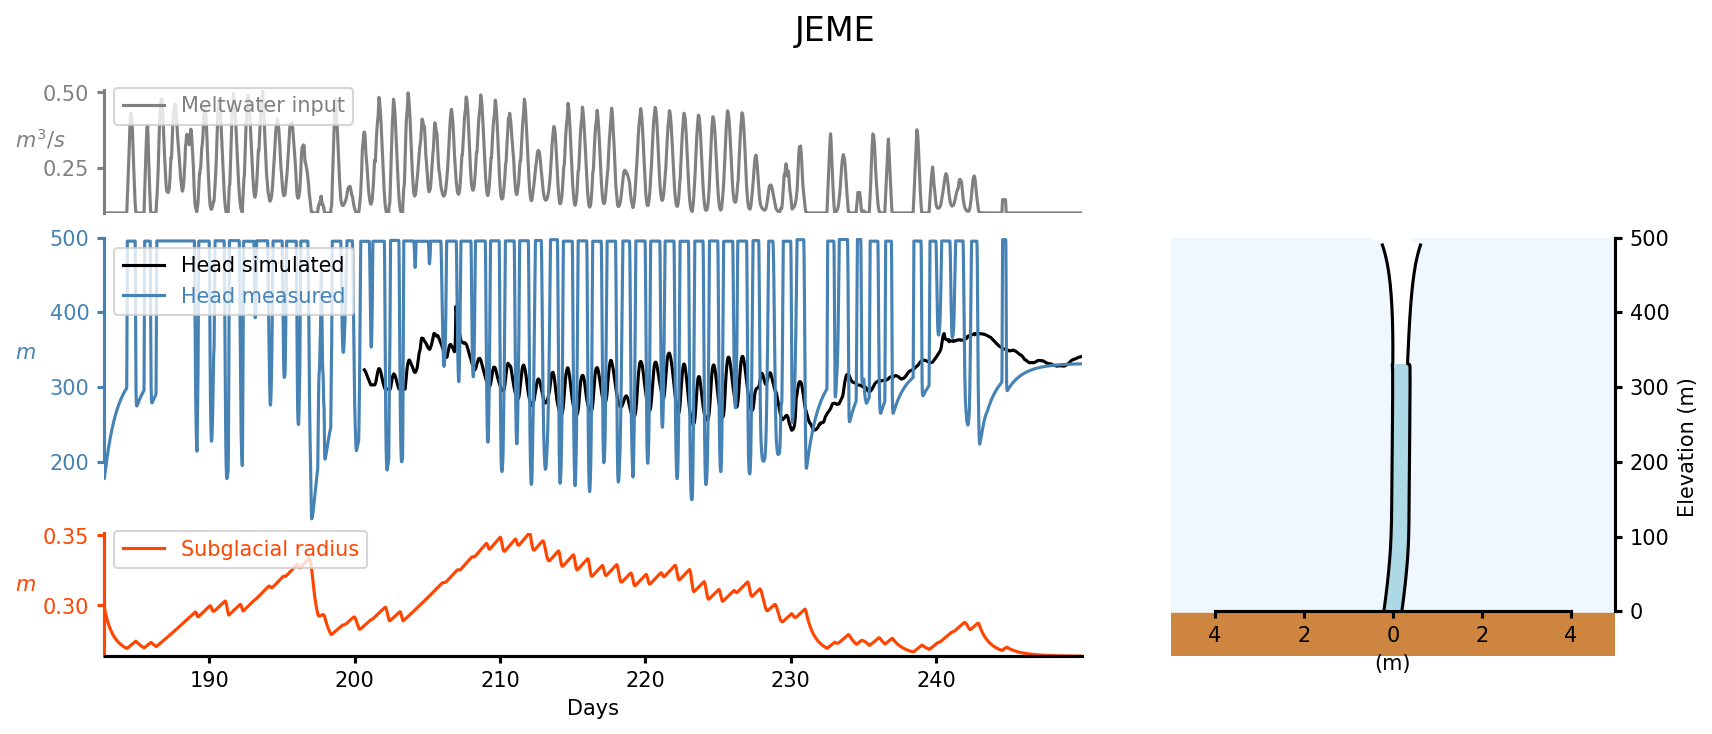

In [8]:
jeme_smallE,params_jeme_smallE, time_jeme_smallE = calc_and_make1plot(jeme,
                                                    initial_subglacial_area = (np.pi*0.3**2)/2,
                                                    make_all_plots = make_all_plots, 
                                                    make_directory = make_directory,  
                                                    creep_factor = 0)



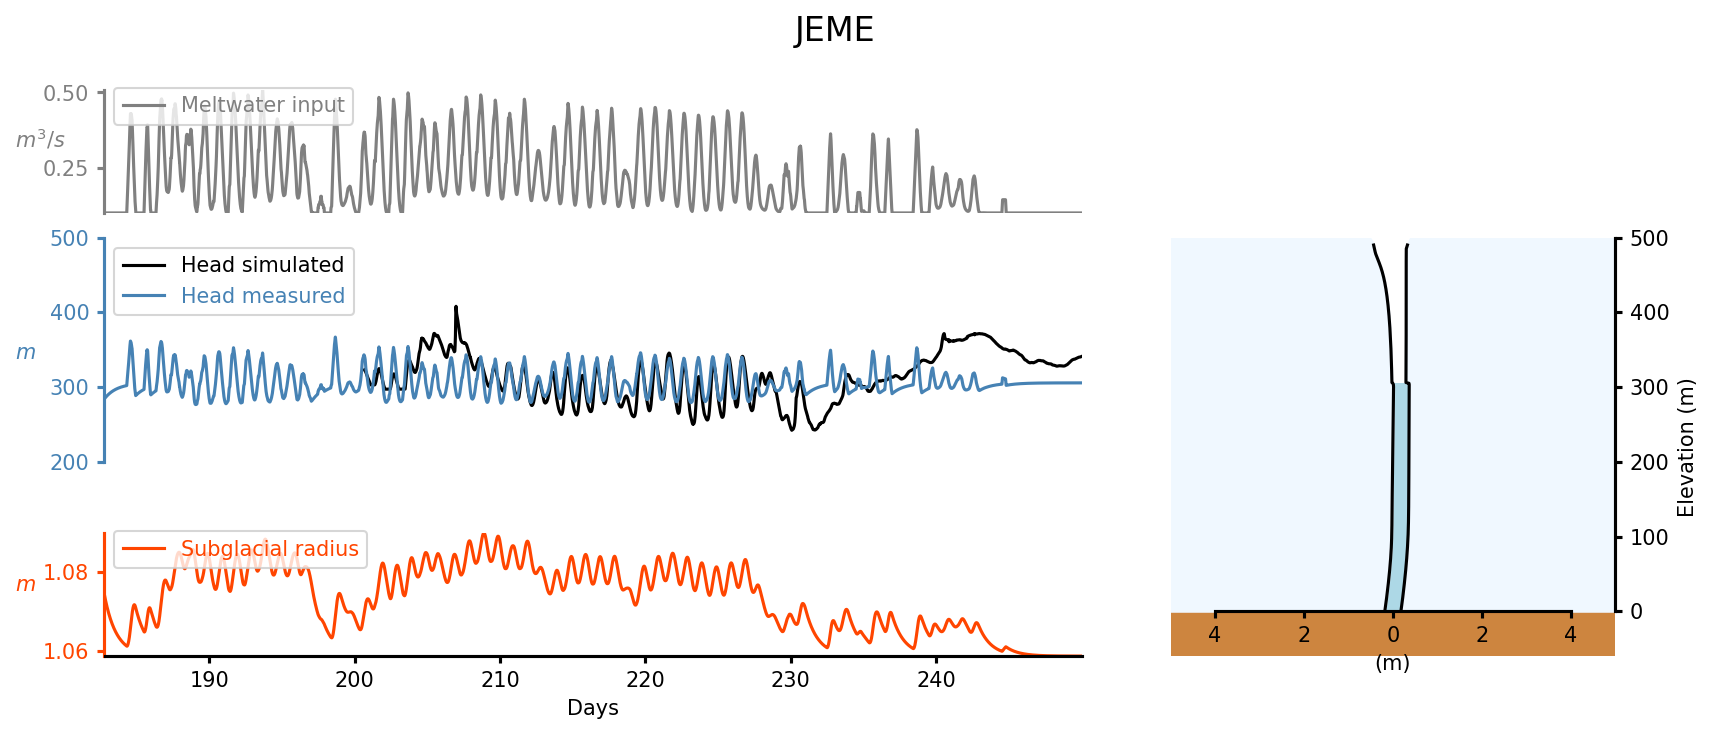

In [9]:
jeme_bf3,params_jeme_bf3, time_jeme_bf3 = calc_and_make1plot(jeme, 
                                              initial_subglacial_area = (np.pi*1.075**2)/2,
                                              make_all_plots = make_all_plots, 
                                              make_directory = make_directory,  
                                              baseflow = 3)


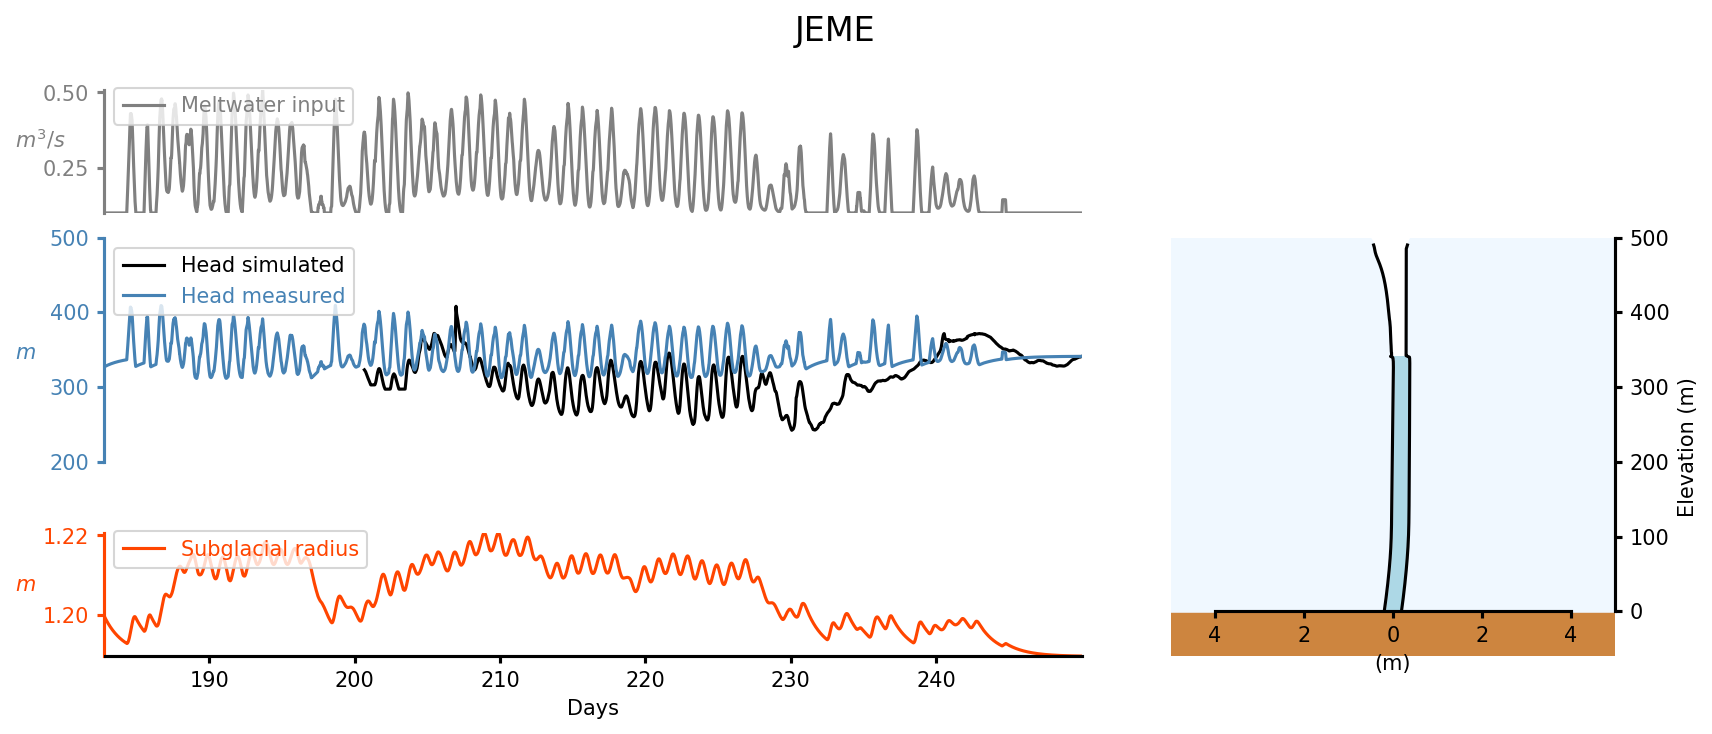

In [15]:
jeme_bf3_largeCH,params_jeme_bf3_largeCH, time_jeme_bf3_largeCH = calc_and_make1plot(jeme, 
                                                              initial_subglacial_area = (np.pi*1.2**2)/2,
                                                              make_all_plots = make_all_plots, 
                                                              make_directory = make_directory,  
                                                              baseflow = 3, 
                                                              channel_length = 50000)


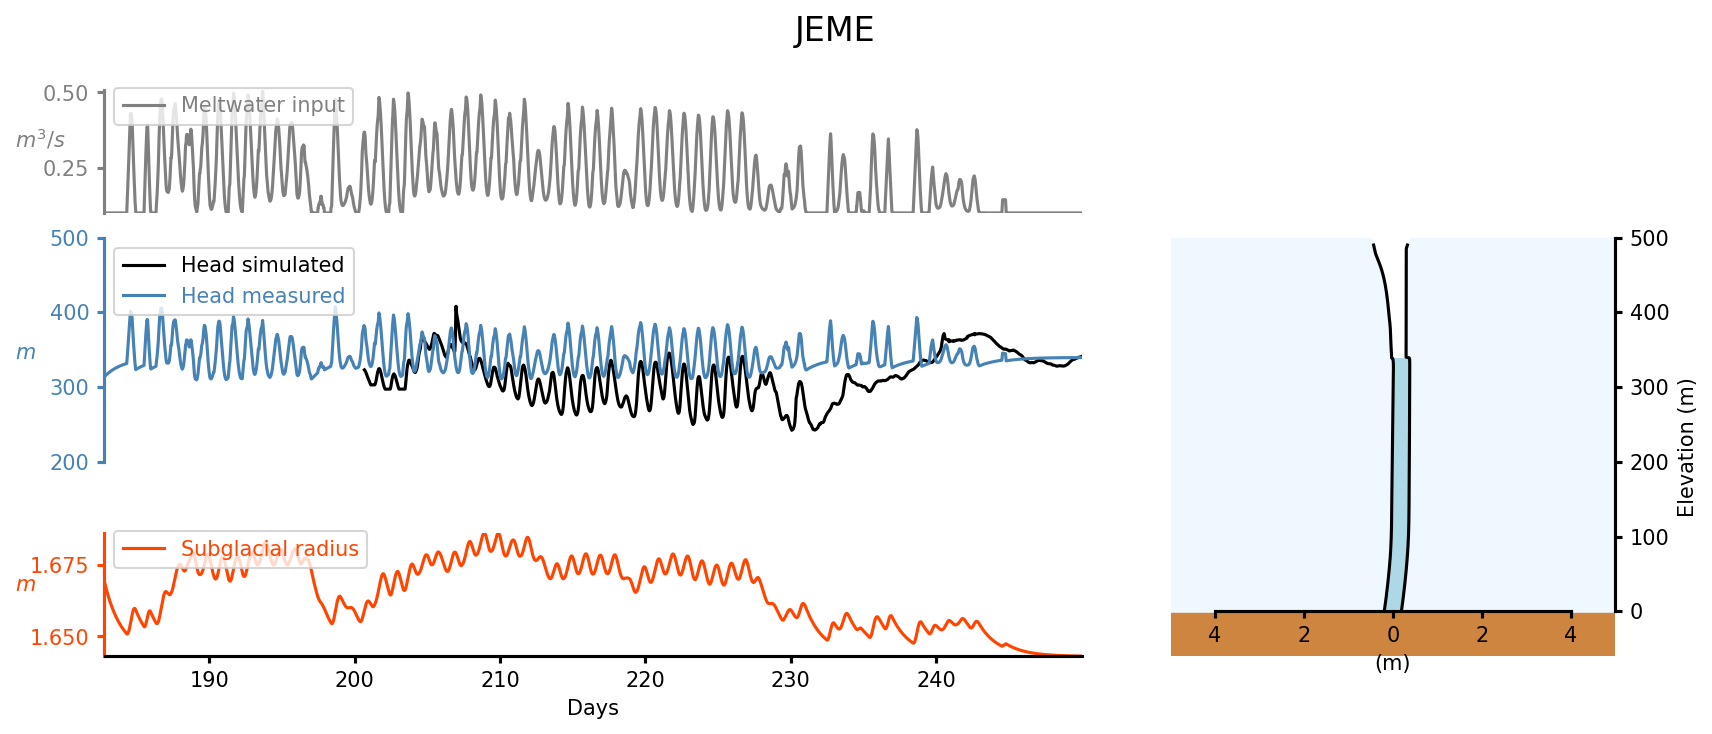

In [17]:
jeme_bf3_largef,params_jeme_bf3_largef, time_jeme_bf3_largef = calc_and_make1plot(jeme, 
                                                            initial_subglacial_area = (np.pi*1.67**2)/2,
                                                            make_all_plots = make_all_plots, 
                                                            make_directory = make_directory,  
                                                            baseflow = 3, 
                                                            friction = 1)

In [29]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def extract_radius(moulin_sim):
    radius = np.zeros(len(moulin_sim.dict['head']))
    for idx in np.arange(len(moulin_sim.dict['head'])):
        head = jeme_brut.dict['head'][idx]
        idx_position = find_nearest(moulin_sim.z,head)
        radius[idx] = moulin_sim.listdict[idx]['moulin_radius_major'][idx_position]
    return radius

radius_jeme_brut = extract_radius(jeme_brut)
radius_jeme_bf3 = extract_radius(jeme_bf3)

plt.figure()
plt.plot(jeme_brut.dict['time'] , radius_jeme_brut, label= 'brut')
plt.plot(jeme_bf3.dict['time'] , radius_jeme_bf3, label= 'baseflow 3')
plt.legend()

#fig, ax = plt.subplots()

In [22]:
type(jeme_brut.dict['time'])


list